In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [8]:
from os.path import exists, join, splitext

In [9]:
config_filename = 'uncer.yaml'
config1 = read_config(config_filename)
config2 = read_config('default.yaml')

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_20112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 236513.43           | 238242.43           | 240335.0            | 241935.0            | 243169.0   

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  2%|▏         | 11/500 [00:00<00:04, 103.68it/s]

Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.3669025231101817,
    'I_hosp_ratio': 1.2402147454038883,
    'P_fatal': 1.208978055624627,
    'T_inc': 1.0541890195174228,
    'T_inf': 1.137987369387785,
    'T_recov': 1.4376008311653838,
    'T_recov_fatal': 1.6751579002018322,
    'lockdown_R0': 1.3244024757947717,
    'sigma': 6.2602935412018414}


100%|██████████| 500/500 [00:04<00:00, 102.13it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.8061125801123458), ('T_inc', 4.1845106191156765), ('T_inf', 4.451784283308082), ('T_recov', 11.726650853696384), ('T_recov_fatal', 20.78199051505495), ('P_fatal', 0.02945525420837428), ('E_hosp_ratio', 0.34581921472797417), ('I_hosp_ratio', 0.39209897727076004), ('sigma', 2.3326578041512565)])
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_20112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharash

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 500/500 [00:12<00:00, 39.46trial/s, best loss: 1.372710481592998] 
best parameters
 {'E_hosp_ratio': 0.00028585545778329197, 'I_hosp_ratio': 0.5736882517425, 'P_fatal': 0.02020450417323786, 'T_inc': 4.190172684591457, 'T_inf': 3.6638452467020093, 'T_recov': 11.936451860553813, 'T_recov_fatal': 18.53535044403899, 'lockdown_R0': 0.870751560102141}


15it [00:00, 148.68it/s]

getting forecasts ..
getting forecasts ..


500it [00:03, 142.92it/s]
12it [00:00, 115.59it/s]

getting forecasts ..
getting forecasts ..


500it [00:03, 131.42it/s]
12it [00:00, 112.96it/s]

getting forecasts ..


500it [00:03, 139.75it/s]


KeyError: 'm2'

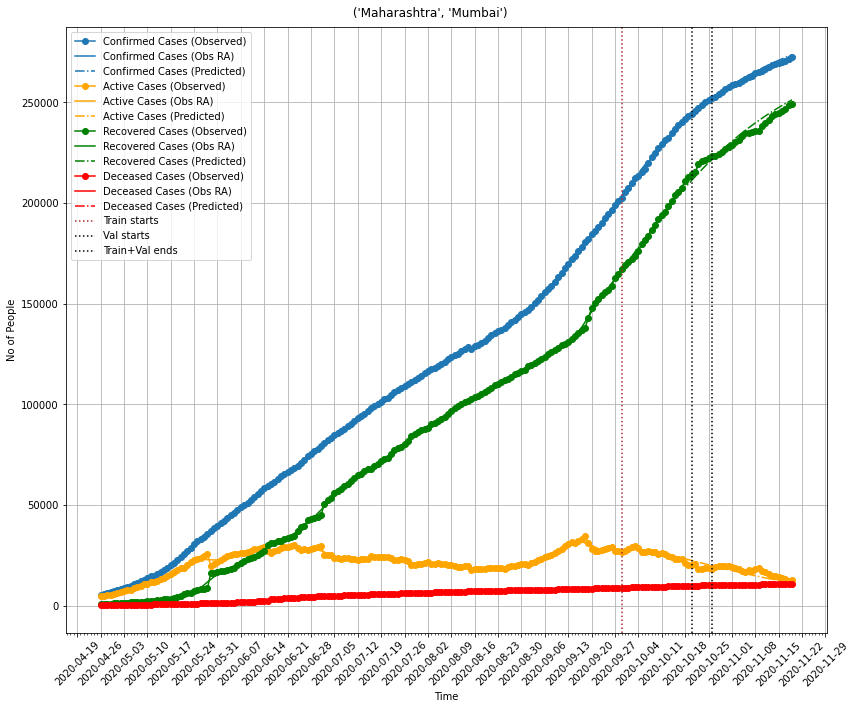

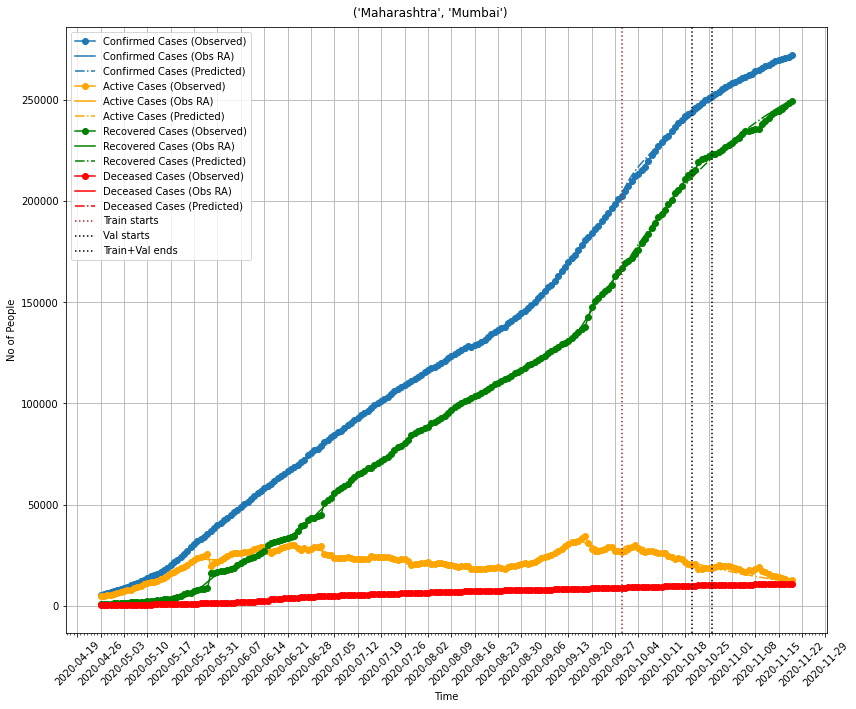

In [11]:
runs = 10
mcmc_P = []
bo_P = []
mcmc_perc_loss = []
bo_perc_loss = []
k = []
for n in range(runs):
    percentile_dict1 = {}
    percentile_dict2 = {}
    percentile_dict1['m1'] = single_fitting_cycle(**copy.deepcopy(config1['fitting']))
    percentile_dict2['m1'] = single_fitting_cycle(**copy.deepcopy(config2['fitting']))
    percentile_dict1['m1']['forecasts'] = {}
    percentile_dict1['m1']['forecasts']['best'] = get_forecast(percentile_dict1, train_fit='m1', 
                                                            model=config1['fitting']['model'], 
                                                            forecast_days=config1['forecast']['forecast_days'])

    percentile_dict1['m1']['trials_processed'] = forecast_all_trials(percentile_dict1, train_fit='m1', 
                                                                    model=config1['fitting']['model'], 
                                                                    forecast_days=config1['forecast']['forecast_days'])
    percentile_dict2['m1']['forecasts'] = {}
    percentile_dict2['m1']['forecasts']['best'] = get_forecast(percentile_dict2, train_fit='m1', 
                                                            model=config2['fitting']['model'], 
                                                            forecast_days=config2['forecast']['forecast_days'])

    percentile_dict2['m1']['trials_processed'] = forecast_all_trials(percentile_dict2, train_fit='m1', 
                                                                    model=config2['fitting']['model'], 
                                                                    forecast_days=config2['forecast']['forecast_days'])

    uncertainty_args1 = {'predictions_dict': percentile_dict1, **config1['uncertainty']['uncertainty_params']}
    uncertainty1 = config1['uncertainty']['method'](**uncertainty_args1)
    uncertainty_args2 = {'predictions_dict': percentile_dict2, 'fitting_config': config2['fitting'],
                    'forecast_config': config2['forecast'], **config2['uncertainty']['uncertainty_params']}
    uncertainty = config2['uncertainty']['method'](**uncertainty_args2)
    uncertainty_forecasts1 = uncertainty1.get_forecasts()
    uncertainty_forecasts2 = uncertainty2.get_forecasts()
    mcmc = []
    bo = []
    key = []
    for i in uncertainty_forecasts1.keys():
        key.append(i)
        mcmc.append(uncertainty_forecasts1[i]['df_loss_perc'].mean())
        bo.append(uncertainty_forecasts2[i]['df_loss_perc'].mean())
    k = key
    mcmc_perc_loss.append(mcmc)
    bo_perc_loss.append(bo)
    mcmc_P.append(uncertainty1.p_val)
    bo_P.append(uncertainty2.p_val)
    

In [5]:
percentile_dict1 = {}
percentile_dict2 = {}

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_20112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 236513.43           | 238242.43           | 240335.0            | 241935.0            | 243169.0   

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  1%|          | 8/1500 [00:00<00:20, 73.71it/s]

Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.5435241403582558,
    'I_hosp_ratio': 1.3192108196037755,
    'P_fatal': 1.298715643358172,
    'T_inc': 1.0518864029533637,
    'T_inf': 1.3258508749192317,
    'T_recov': 1.2133157417308138,
    'T_recov_fatal': 1.3974870772597348,
    'lockdown_R0': 1.0382645791042378,
    'sigma': 5.943711428240654}


100%|██████████| 1500/1500 [00:17<00:00, 85.40it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.8382519151697913), ('T_inc', 4.031458644952099), ('T_inf', 3.8319714252657695), ('T_recov', 10.587175947070351), ('T_recov_fatal', 32.91255087144158), ('P_fatal', 0.043945182272098905), ('E_hosp_ratio', 0.23727353623923852), ('I_hosp_ratio', 0.4402692308640674), ('sigma', 2.8034970039523843)])
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_20112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharash

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 500/500 [00:15<00:00, 31.77trial/s, best loss: 0.9846127831918507]
best parameters
 {'E_hosp_ratio': 0.23312422249918877, 'I_hosp_ratio': 0.4123415584453204, 'P_fatal': 0.03973465727490741, 'T_inc': 4.898627136256456, 'T_inf': 3.5701257750030146, 'T_recov': 10.612426161008555, 'T_recov_fatal': 33.180347033163265, 'lockdown_R0': 0.9182725582507328}


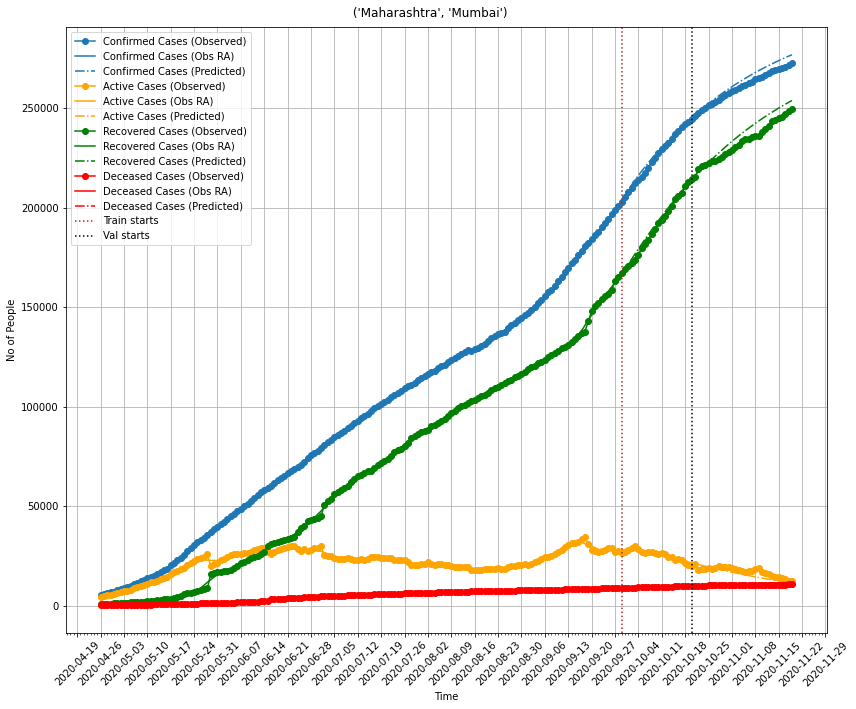

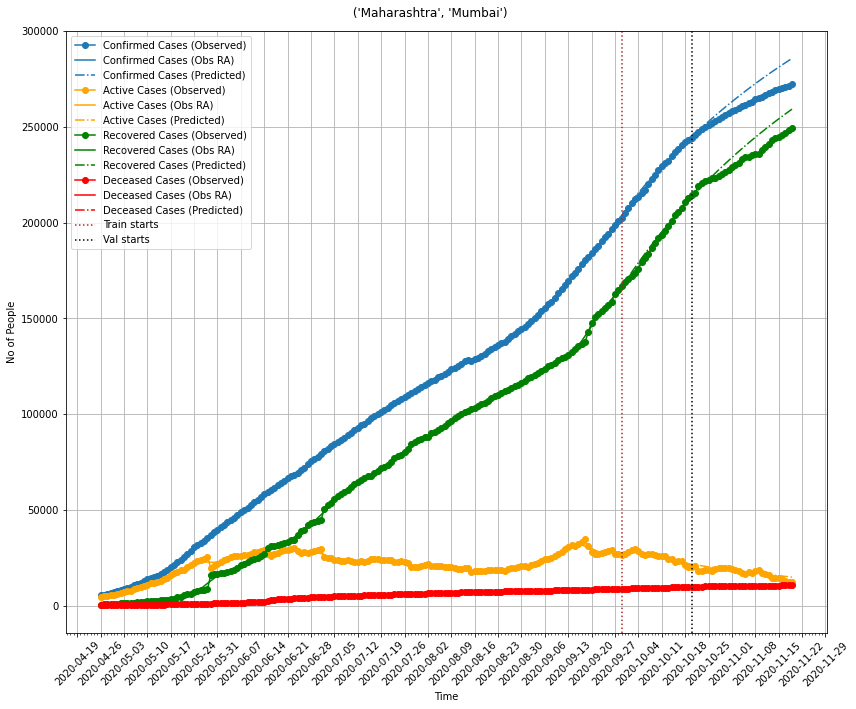

In [6]:
percentile_dict1['m1'] = single_fitting_cycle(**copy.deepcopy(config1['fitting']))
percentile_dict2['m1'] = single_fitting_cycle(**copy.deepcopy(config2['fitting']))

In [7]:
for i in percentile_dict1['m1'].keys():
    print(i)

plots
best_params
default_params
variable_param_ranges
optimiser
df_prediction
df_district
df_train
df_val
df_loss
trials
data_last_date
smoothing_description
df_district_unsmoothed
run_params


In [8]:
percentile_dict1['m1']['df_loss']
from main.seir.forecast import _get_top_k_trials as topk
_,loss = topk(percentile_dict1['m1'], k = 10)
loss

array([0.78997242, 0.78997242, 0.80069202, 0.80069202, 0.80069202,
       0.80069202, 0.80069202, 0.80069202, 0.80069202, 0.80069202])

In [9]:
percentile_dict1['m1']['df_loss']
from main.seir.forecast import _get_top_k_trials as topk
_,loss = topk(percentile_dict2['m1'], k = 10)
loss

array([0.98461278, 1.01811087, 1.09040273, 1.30240227, 1.33159293,
       1.40748774, 1.45753959, 1.57900372, 1.60090976, 1.63899617])

In [10]:
percentile_dict2['m1']['df_loss']

,train,val
total,0.356094,0.466962
active,3.51639,10.4832
recovered,0.761374,0.43524
deceased,0.286263,0.164389


In [11]:
percentile_dict1['m1']['forecasts'] = {}
percentile_dict1['m1']['forecasts']['best'] = get_forecast(percentile_dict1, train_fit='m1', 
                                                           model=config1['fitting']['model'], 
                                                           days=config1['forecast']['forecast_days'])

percentile_dict1['m1']['trials_processed'] = forecast_all_trials(percentile_dict1, train_fit='m1', 
                                                                 model=config1['fitting']['model'], 
                                                                 forecast_days=config1['forecast']['forecast_days'])

0it [00:00, ?it/s]

getting forecasts ..
getting forecasts ..


1500it [00:12, 120.54it/s]


In [12]:
percentile_dict2['m1']['forecasts'] = {}
percentile_dict2['m1']['forecasts']['best'] = get_forecast(percentile_dict2, train_fit='m1', 
                                                           model=config2['fitting']['model'], 
                                                           days=config2['forecast']['forecast_days'])

percentile_dict2['m1']['trials_processed'] = forecast_all_trials(percentile_dict2, train_fit='m1', 
                                                                 model=config2['fitting']['model'], 
                                                                 forecast_days=config2['forecast']['forecast_days'])

13it [00:00, 127.63it/s]

getting forecasts ..
getting forecasts ..


500it [00:03, 133.70it/s]


In [13]:
uncertainty_args1 = {'predictions_dict': percentile_dict1, **config1['uncertainty']['uncertainty_params']}
uncertainty1 = config1['uncertainty']['method'](**uncertainty_args1)

In [ ]:
uncertainty_args2 = {'predictions_dict': percentile_dict2, **config2['uncertainty']['uncertainty_params']}
uncertainty2 = config2['uncertainty']['method'](**uncertainty_args2)

> /Users/avtansht/Desktop/Wadhwani/covid-modelling/main/seir/uncertainty/middleclass.py(203)find_beta()
-> variable_param_ranges[key] = getattr(hp, variable_param_ranges[key][1])(


In [ ]:
print("MCMC-",uncertainty1.p_val)
print("BO-",uncertainty2.p_val)

In [ ]:
uncertainty_forecasts1 = uncertainty1.get_forecasts()
uncertainty_forecasts2 = uncertainty2.get_forecasts()

In [ ]:
mcmc = []
bo = []
key = []
for i in uncertainty_forecasts1.keys():
    key.append(i)
    mcmc.append(uncertainty_forecasts1[i]['df_loss_perc'].mean())
    bo.append(uncertainty_forecasts2[i]['df_loss_perc'].mean())

In [ ]:
np.greater(mcmc,bo).sum()/len(mcmc)

In [ ]:
data = {"mcmc":mcmc,"bo":bo}
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches

In [ ]:
plt.figure(figsize= (15,7))
mc, = plt.plot(key,mcmc,markersize=12,label='MCMC',color='b')
plt.scatter(key,mcmc,color='b')
b, = plt.plot(key,bo,markersize=12,label = 'BO',color='r')
plt.scatter(key,bo,color='r')
plt.legend(handles = [mc,b])
plt.xlabel('Percentiles')
plt.ylabel('Loss in Total compartment')

In [ ]:
np.linspace(0,100,40)